# **Time Series Analysis and Forecasting**

# **Imports**

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import matplotlib
import itertools
import seaborn as sns
import plotly.graph_objs as go
import plotly.io as pio

from plotly.subplots import make_subplots
from prophet import Prophet
from pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 18, 8

import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

In [2]:
df = pd.read_excel("D:\Coding Dojo\Data\Sample - Superstore.xlsm")

In [3]:
df.head()

Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08 2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12 2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11 2015-10-18  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10001798        Furniture    Bookcases   
1       42420   South  FUR-CH-10000454        Furniture       Chairs   
2       90036    West  OFF-LA-10000240  Office Supplies       Labels   
3       33311   South  FUR-TA-10000577        Furniture       Tables   
4       33311   South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200         2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775         5   
4                     Eldon Fold 'N Roll Cart System   22.3680         2   

   Discount    Profit  
0      0.00   41.9136  
1      0.00  219.5820  
2      0.00    6.8714  
3      0.45 -383.0310  
4      0.20    2.5164  

[5 rows x 21 columns]

# **Forcasting for Furniture Sales**

In [4]:
furniture = df.loc[df['Category'] == 'Furniture']

In [5]:
# We have a good 4-year furniture sales data.
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

## **Data Preprocessing**

In [6]:
# This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [7]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

## **Indexing with Time Series Data**

In [8]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [9]:
# Using the Average daily Sales.
y = furniture['Sales'].resample('MS').mean()

In [10]:
# Looking at 2017.
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## **Visualizing Furniture Sales Time Series Data**

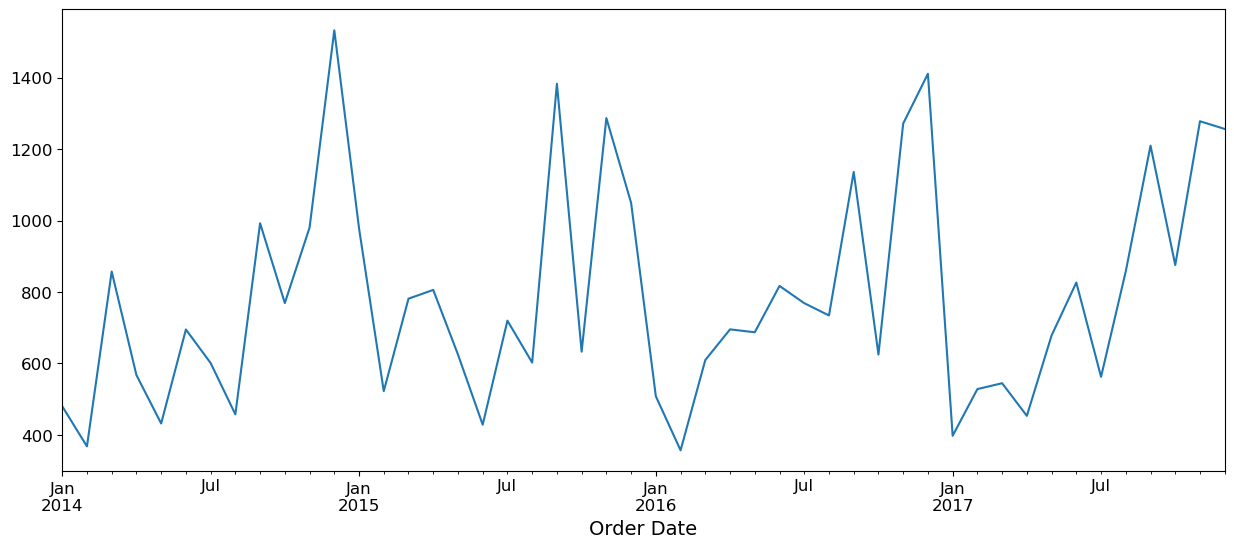

In [11]:
# Ploting Furniture Sales for four years (2014-2017).
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always a strong upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

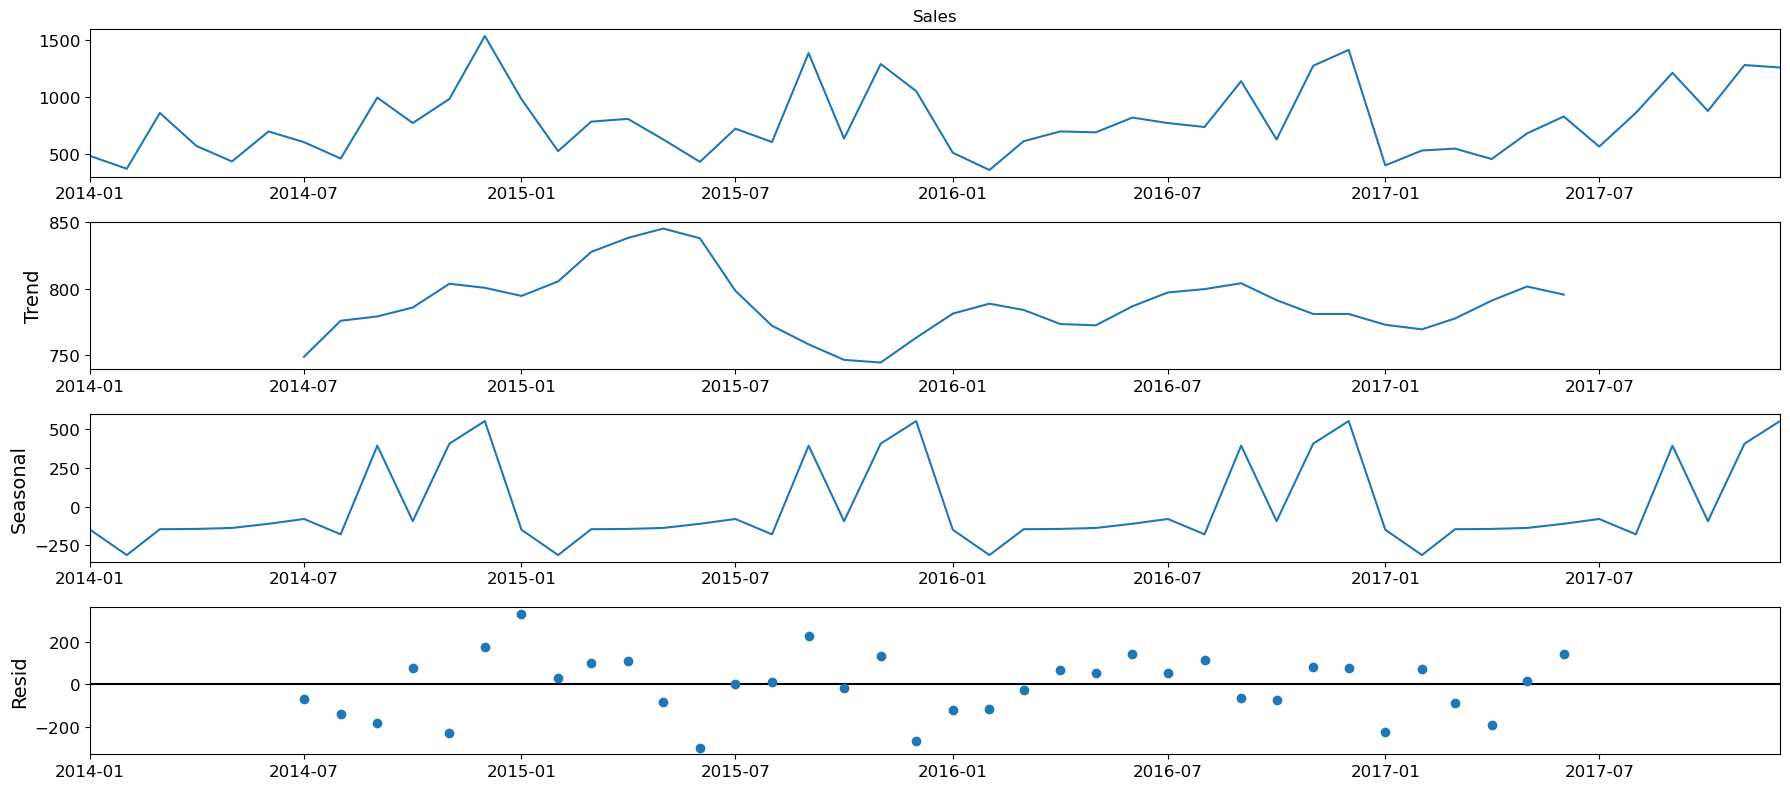

In [12]:
# Visualize our data using decomposition method.
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

- Decomposed our time series into three distinct components: trend, seasonality, and noise.

- **The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.**

# **Time Series Forcasting with ARIMA**

In [13]:
#ARIMA models are denoted with the notation ARIMA(p, d, q). These three parameters account for seasonality, trend, and noise in data: 
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


This step is parameter Selection for our furniture’s sales ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.

In [14]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523335078
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1432.3858091709621
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130918252
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.2702899793693
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1462.730824462368
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803030596
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758095
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2623.450652887499
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091517
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.62613896732944
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.59762668894086
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2516.7823165759187
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946867
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.87255765116885
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668414504
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1364.7536921420217
AR

The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 297.78. Therefore we should consider this to be optimal option.

## **Fitting the ARIMA model**

In [15]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                #enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0676      0.226      0.299      0.765      -0.376       0.511
ma.L1         -1.0000      0.279     -3.590      0.000      -1.546      -0.454
ar.S.L12      -0.4807      0.147     -3.260      0.001      -0.770      -0.192
sigma2      4.108e+04   6.78e-06   6.06e+09      0.000    4.11e+04    4.11e+04


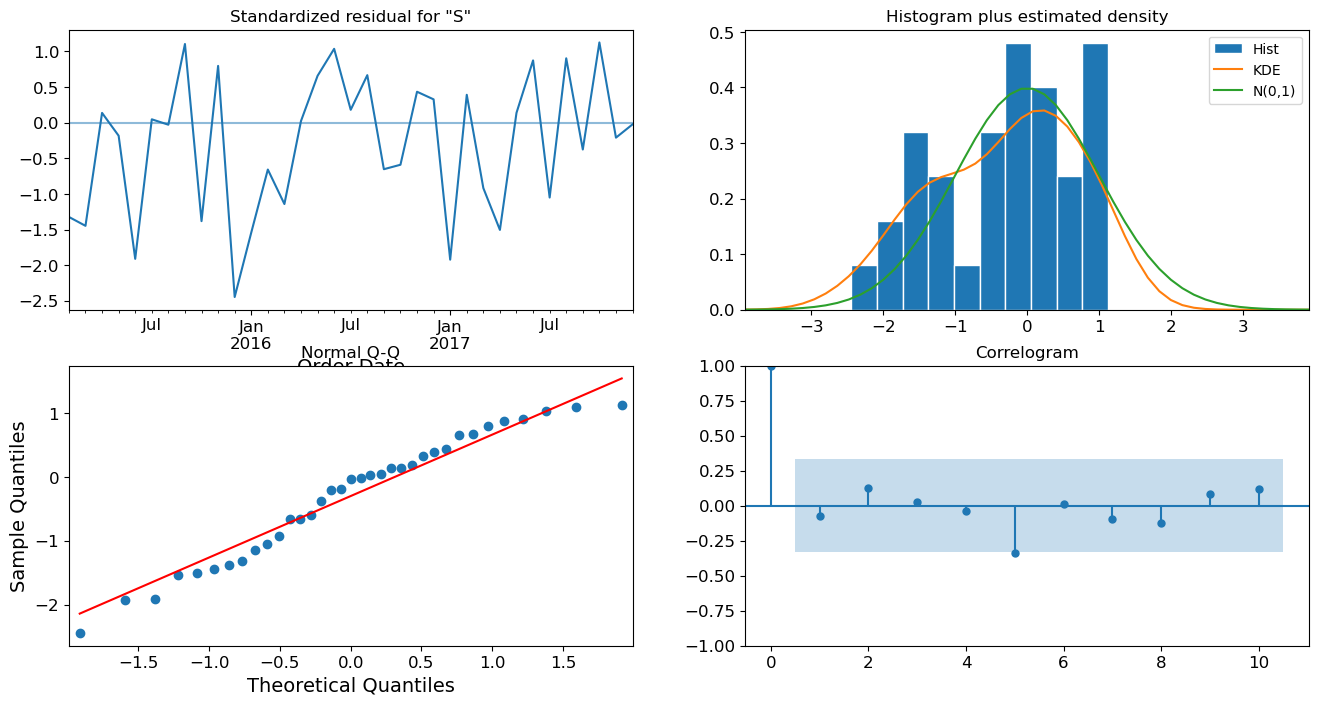

In [16]:
# Plot diagnostic results
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# **Validating Forcasts**

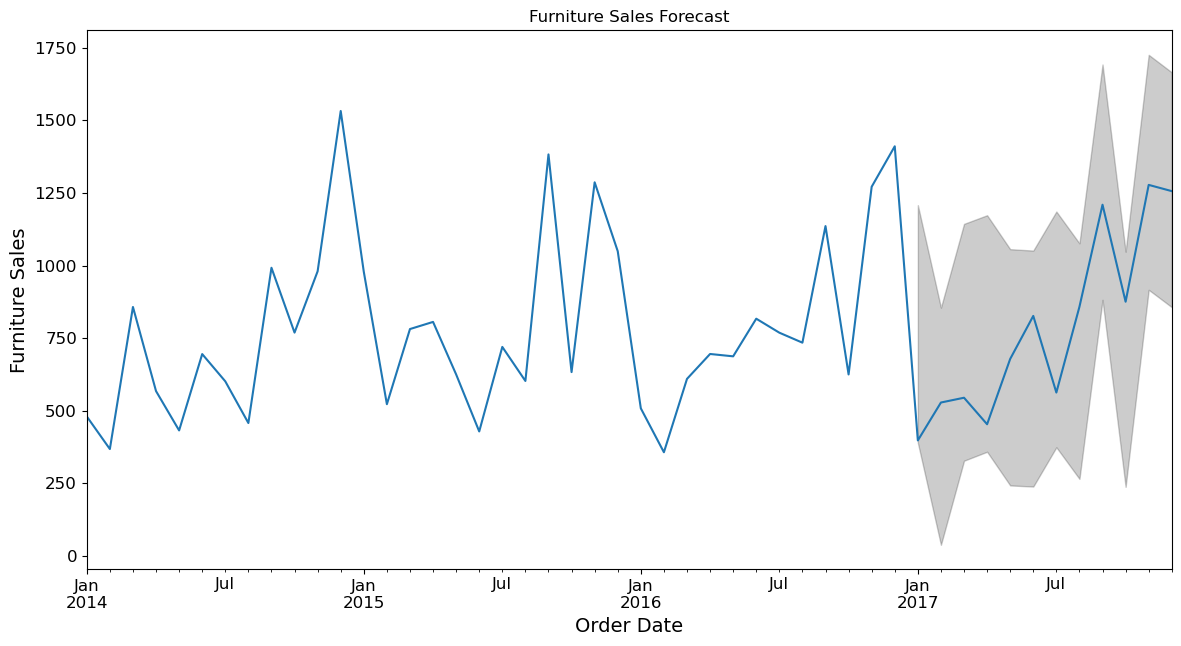

In [17]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(14,7))
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
ax.set_title('Furniture Sales Forecast')

# Plot observed data
y['2014':].plot(ax=ax, label='observed')

# Plot predicted data and confidence interval
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.plot(pred.predicted_mean.index, pred.predicted_mean.values, label='One-step ahead Forecast', alpha=.7)

# Create the plotly figure object
fig = go.Figure(data=[go.Scatter(x=pred.predicted_mean.index, y=pred.predicted_mean.values, mode='lines', name='One-step ahead Forecast'),
                      go.Scatter(x=y.index, y=y.values, mode='lines', name='Observed'),
                      go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 0].values, mode='lines', name='Lower CI', line=dict(width=0)),
                      go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 1].values, mode='lines', name='Upper CI', fill='tonexty', line=dict(width=0))],
                layout=go.Layout(title='Interactive Furniture Sales Forecast', xaxis=dict(title='Date'), yaxis=dict(title='Furniture Sales')))

# Show the interactive plot in a Jupyter notebook or in a web browser
fig.show()

In [18]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 39996.01


In [19]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 199.99


# **Producing and visualizing forecasts**

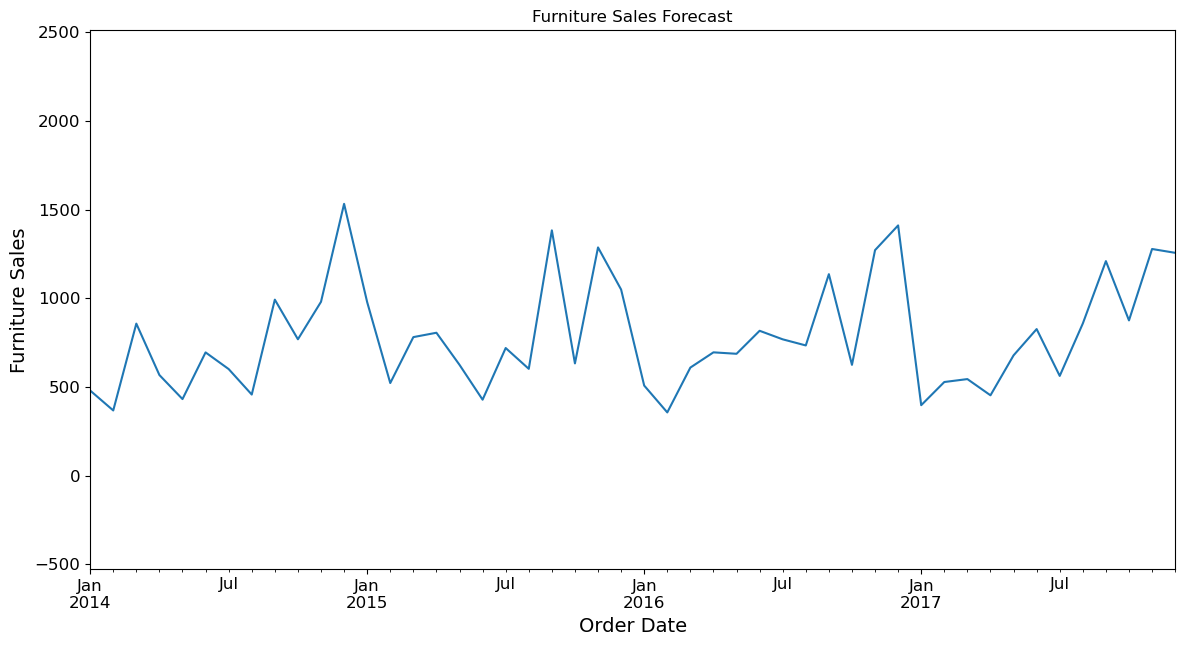

In [20]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

fig, ax = plt.subplots(figsize=(14,7))
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
ax.set_title('Furniture Sales Forecast')

# Plot observed data
y.plot(ax=ax, label='observed')

# Plot predicted data and confidence interval
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.plot(pred_uc.predicted_mean.index, pred_uc.predicted_mean.values, label='Forecast')

# Create the plotly figure object
fig = go.Figure(data=[go.Scatter(x=pred_uc.predicted_mean.index, y=pred_uc.predicted_mean.values, mode='lines', name='Forecast'),
                      go.Scatter(x=y.index, y=y.values, mode='lines', name='Observed'),
                      go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 0].values, mode='lines', name='Lower CI', line=dict(width=0)),
                      go.Scatter(x=pred_ci.index, y=pred_ci.iloc[:, 1].values, mode='lines', name='Upper CI', fill='tonexty', line=dict(width=0))],
                layout=go.Layout(title='Interactive Furniture Sales Forecast', xaxis=dict(title='Date'), yaxis=dict(title='Furniture Sales')))

# Show the interactive plot in a Jupyter notebook or in a web browser
fig.show()

# **Time Series of Furniture vs. Office Supplies**

In [21]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

## **Data Exploration**

In [22]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()
furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

Order Date  furniture_sales  office_sales
0 2014-01-01       480.194231    285.357647
1 2014-02-01       367.931600     63.042588
2 2014-03-01       857.291529    391.176318
3 2014-04-01       567.488357    464.794750
4 2014-05-01       432.049188    324.346545

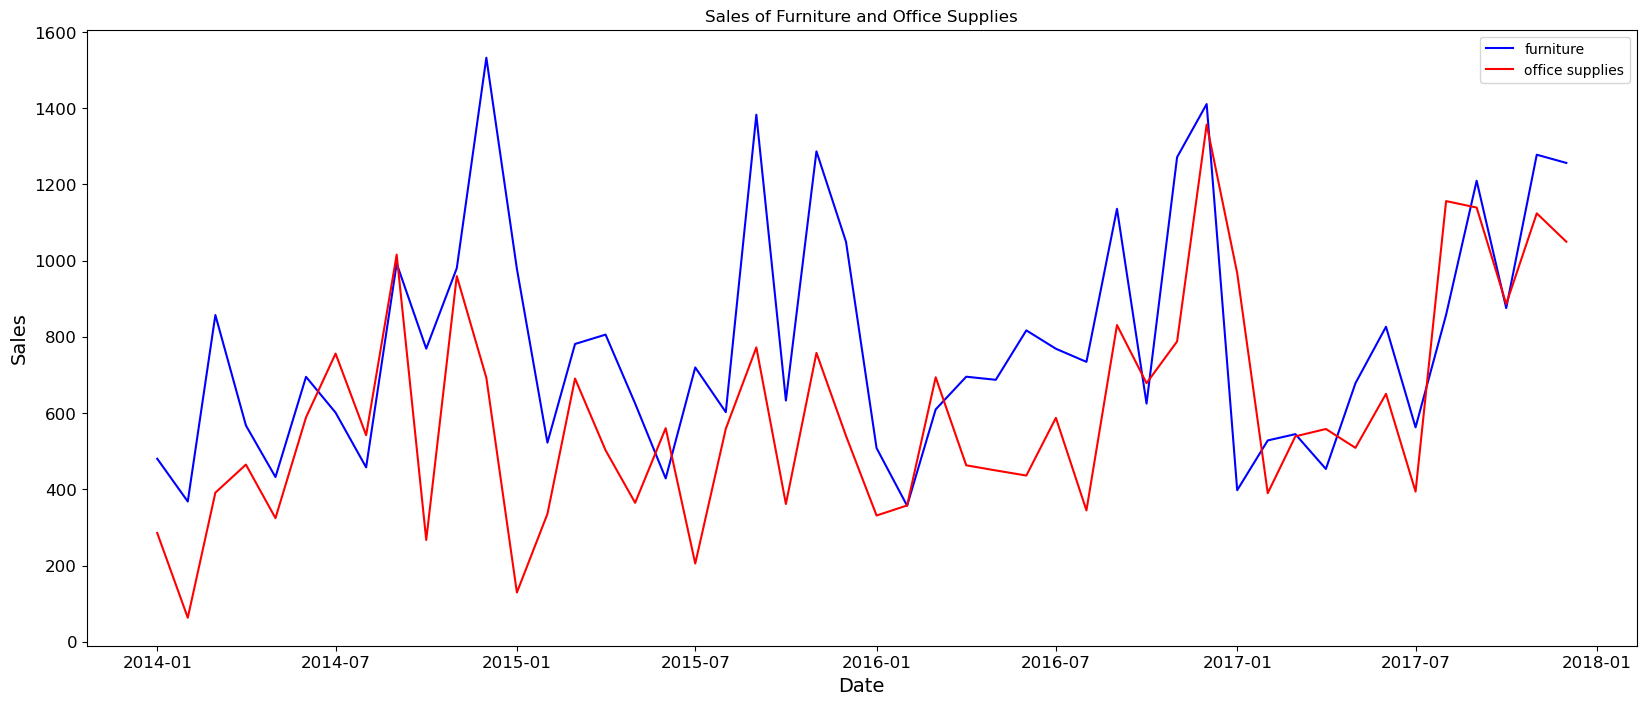

In [23]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

In [24]:
first_date = store.iloc[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), store.columns.get_loc('Order Date')]
print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2014-07-01.


# **Time Series Modeling with Prophet**

<Figure size 1800x600 with 0 Axes>

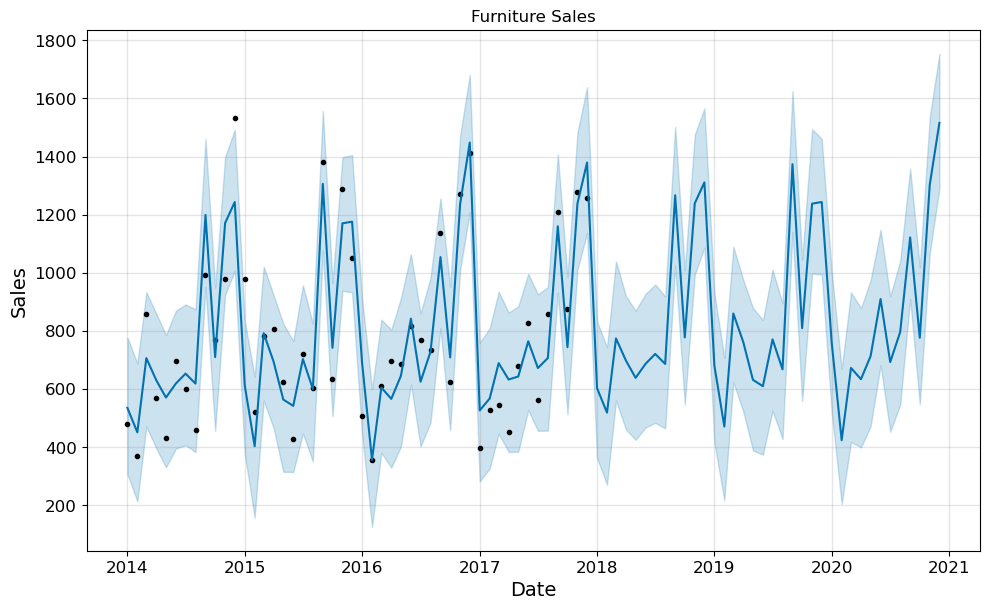

<Figure size 1800x600 with 0 Axes>

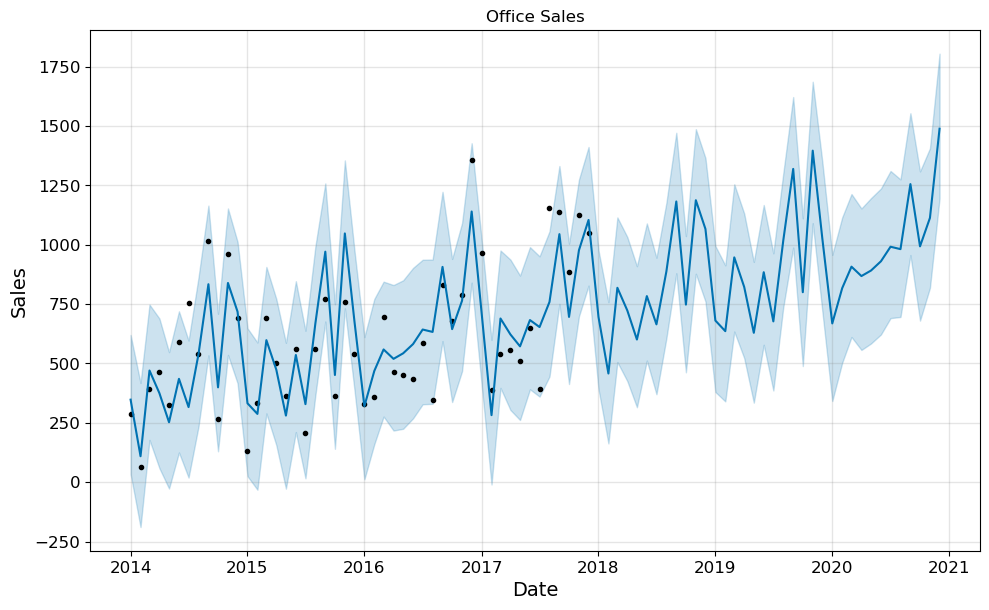

In [25]:
# Rename the columns to ds and y
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
# Initialize the Prophet models
furniture_model = Prophet(interval_width=0.95, weekly_seasonality=False, daily_seasonality=False)
office_model = Prophet(interval_width=0.95, weekly_seasonality=False, daily_seasonality=False)
# Fit the models to the data
furniture_model.fit(furniture)
office_model.fit(office)
# Make future dataframes for 36 periods with a monthly frequency
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
# Predict the future values for the dataframes
furniture_forecast = furniture_model.predict(furniture_forecast)
office_forecast = office_model.predict(office_forecast)
# Plot the forecasts for furniture and office sales
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel='Date', ylabel='Sales')
plt.title('Furniture Sales')
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel='Date', ylabel='Sales')
plt.title('Office Sales')
plt.show()

<Figure size 1800x600 with 0 Axes>

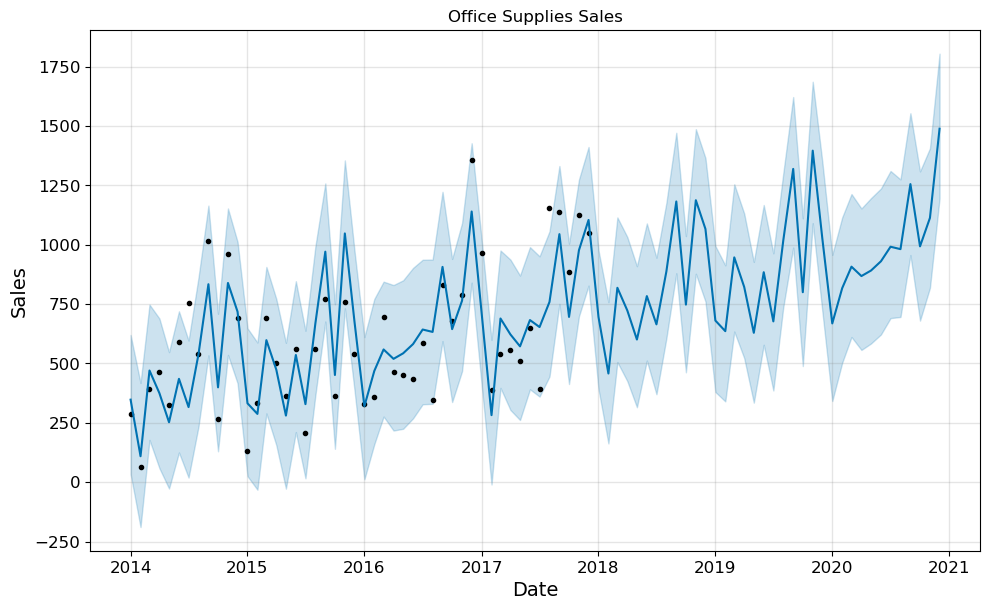

In [26]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

# **Compare Forecasts**

In [27]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names
forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')
forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

Date  furniture_trend  furniture_yhat_lower  furniture_yhat_upper  \
0 2014-01-01       726.058109            307.508361            777.613596   
1 2014-02-01       727.494421            213.414466            688.233827   
2 2014-03-01       728.791734            471.191174            933.366186   
3 2014-04-01       730.228046            395.855658            859.280700   
4 2014-05-01       731.618025            330.601097            785.530794   

   furniture_trend_lower  furniture_trend_upper  furniture_additive_terms  \
0             726.058109             726.058109               -190.686099   
1             727.494421             727.494421               -276.379157   
2             728.791734             728.791734                -22.388253   
3             730.228046             730.228046               -100.140909   
4             731.618025             731.618025               -160.818882   

   furniture_additive_terms_lower  furniture_additive_terms_upper  \
0                     -190.686099                     -190.686099   
1                     -276.379157                     -276.379157   
2                      -22.388253                      -22.388253   
3                     -100.140909                     -100.140909   
4                     -160.818882                     -160.818882   

   furniture_yearly  ...  office_additive_terms  office_additive_terms_lower  \
0       -190.686099  ...            -140.041115                  -140.041115   
1       -276.379157  ...            -385.677761                  -385.677761   
2        -22.388253  ...             -31.378526                   -31.378526   
3       -100.140909  ...            -134.290665                  -134.290665   
4       -160.818882  ...            -263.823552                  -263.823552   

   office_additive_terms_upper  office_yearly  office_yearly_lower  \
0                  -140.041115    -140.041115          -140.041115   
1                  -385.677761    -385.677761          -385.677761   
2                   -31.378526     -31.378526           -31.378526   
3                  -134.290665    -134.290665          -134.290665   
4                  -263.823552    -263.823552          -263.823552   

   office_yearly_upper  office_multiplicative_terms  \
0          -140.041115                          0.0   
1          -385.677761                          0.0   
2           -31.378526                          0.0   
3          -134.290665                          0.0   
4          -263.823552                          0.0   

   office_multiplicative_terms_lower  office_multiplicative_terms_upper  \
0                                0.0                                0.0   
1                                0.0                                0.0   
2                                0.0                                0.0   
3                                0.0                                0.0   
4                                0.0                                0.0   

   office_yhat  
0   347.489370  
1   109.240405  
2   470.212385  
3   374.687928  
4   252.304409  

[5 rows x 31 columns]

# **Trend and Forecast Visualization**

In [28]:
# Create the Furniture Sales trace
furniture_trace = go.Scatter(x=forecast['Date'], y=forecast['furniture_trend'], mode='lines', name='Furniture Sales')

# Create the Office Supplies Sales trace
office_trace = go.Scatter(x=forecast['Date'], y=forecast['office_trend'], mode='lines', name='Office Supplies Sales')

# Create the plot layout
layout = go.Layout(title='Interactive Furniture vs. Office Supplies Sales Trend', 
                   xaxis=dict(title='Date'), 
                   yaxis=dict(title='Sales'))

# Combine the traces and layout into a figure
fig = go.Figure(data=[furniture_trace, office_trace], layout=layout)

# Display the plot in a Jupyter notebook or in a web browser
pio.show(fig)

In [29]:
# Create the Furniture Estimate trace with blue color
furniture_trace = go.Scatter(x=forecast['Date'], y=forecast['furniture_yhat'], mode='lines', name='Furniture Estimate', line_color='blue')

# Create the Office Supplies Estimate trace with red color
office_trace = go.Scatter(x=forecast['Date'], y=forecast['office_yhat'], mode='lines', name='Office Supplies Estimate', line_color='red')

# Create the plot layout
layout = go.Layout(title='Interactive Furniture vs. Office Supplies Estimate', 
                   xaxis=dict(title='Date'), 
                   yaxis=dict(title='Sales'))

# Combine the traces and layout into a figure
fig = go.Figure(data=[furniture_trace, office_trace], layout=layout)

# Display the plot in a Jupyter notebook or in a web browser
pio.show(fig)

# **Trends and Paterns**

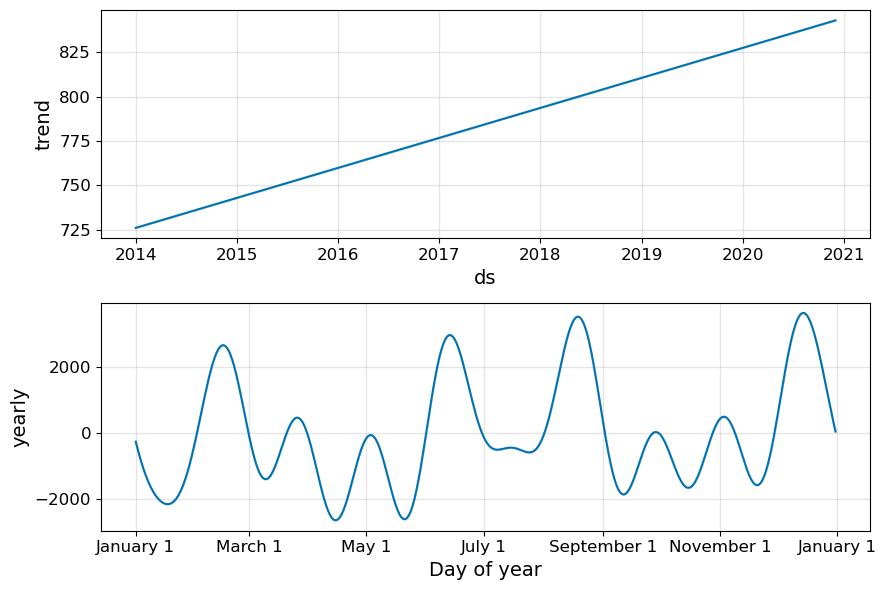

In [30]:
furniture_model.plot_components(furniture_forecast);

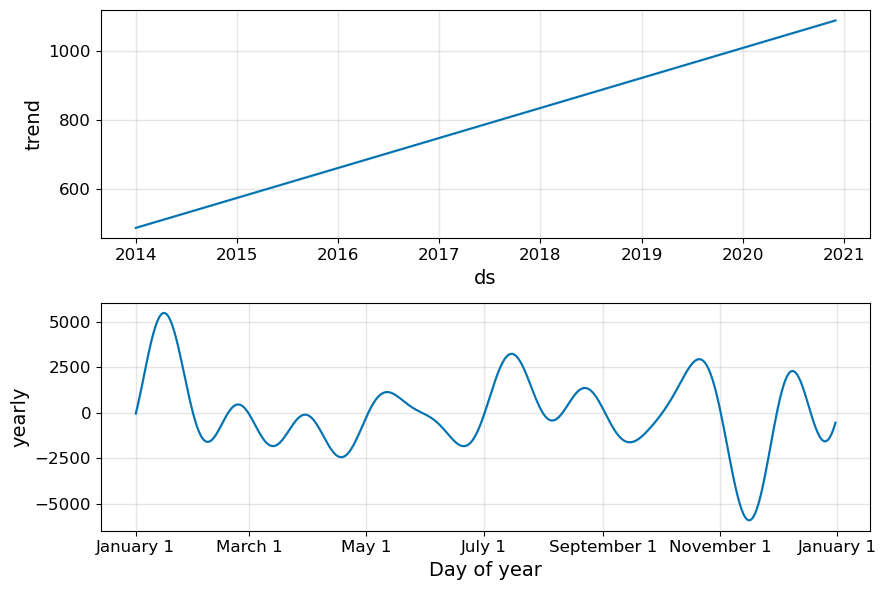

In [31]:
office_model.plot_components(office_forecast);